<a href="https://colab.research.google.com/github/mukeshkharel/Flowise/blob/main/Bilderklassifizierung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing Pytorch, enabling GPU and accessing the Data on Google Drive**

In [ ]:
# Pytorch is already installed on colab, so no pip install :)
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Set GPU device
print(torch.cuda.is_available())
device = torch.device("cuda:0")

True


In [ ]:
# Connect Google Drive with colab (follow the instructions)
from google.colab import drive
drive.mount('/content/google_drive')

Mounted at /content/google_drive


**Manually Loading the data and displaying it**

In [ ]:
# Paths and placeholders for files
train_root = "/content/google_drive/My Drive/NN/Train"
test_root = "/content/google_drive/My Drive/NN/Test"
train_path_dict = {}
test_path_dict = {}

In [ ]:
import os

# Go through all train folders
for subdir, dirs, files in os.walk(train_root):
    wonder = subdir.split("/")[-1]
    paths = []
    for file in files:
        paths.append(os.path.join(subdir, file))
    if wonder != "train":
        train_path_dict[wonder] = paths

# Go through all test folders
for subdir, dirs, files in os.walk(test_root):
    wonder = subdir.split("/")[-1]
    paths = []
    for file in files:
        paths.append(os.path.join(subdir, file))
    if wonder != "test":
        test_path_dict[wonder] = paths

**Pytorch augumented dataset and pytorch dataloader**

In [ ]:
# Load train dataset
train_dataset = torchvision.datasets.ImageFolder(
        root=train_root, # This is the folder containing the image-folders
        transform=transforms.Compose([
                      transforms.Resize((512,512)),
                      transforms.ToTensor()
        ])
)

# Augmentation of the train dataset
augmented_train_dataset = torchvision.datasets.ImageFolder(
        root=train_root,
        transform=transforms.Compose([
                      transforms.RandomResizedCrop((512,512), scale=(0.2, 1.0)),
                      transforms.RandomRotation(20),
                      transforms.RandomHorizontalFlip(),
                      transforms.ToTensor(),
                      # Required for ImageNet models
                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
)

batch_size = 8
# Create the train dataloader
train_loader = torch.utils.data.DataLoader(
    augmented_train_dataset,
    batch_size=batch_size,
    shuffle=True
)



# Also apply normalization to the test dataset
test_dataset = torchvision.datasets.ImageFolder(
        root=test_root,
        transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Resize((512,512)),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    )

test_batch_size = 20
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=True
)

**Transfer Learning - Using pretrained Models**

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

class PretrainedCNN(nn.Module):
    def __init__(self):
        super(PretrainedCNN, self).__init__()

        self.pretrained = models.alexnet(pretrained=True)
       # self.pretrained = models.vgg16(pretrained=True)
       # self.pretrained = models.resnext50_32x4d(pretrained=True)

        # We can freeze the parameters and don't need to calculate gradients
        for param in self.pretrained.parameters():
          param.requires_grad = False

        in_feats = self.pretrained.classifier[6].in_features
        # For resnext50_32x4d
       # in_feats = self.pretrained.fc.in_features

        # Adjust output layer - the only place where learning happens
        self.pretrained.classifier[6] = nn.Linear(in_feats, 10)
        #For resnext50_32x4d
        #self.pretrained.fc = nn.Linear(in_feats, 10)

    def forward(self, x):
        x = self.pretrained(x)
        return x

net = PretrainedCNN()
net.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 184MB/s]


PretrainedCNN(
  (pretrained): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False

Train Model

In [ ]:
def train_model(early_stopping=True, epochs=50):
  """ Training the model in a loop of epochs """
  epoch_train_losses = []
  epoch_test_losses = []
  current_best_loss = np.inf
  early_stopping_counter = 0
  early_stopping_patience = 2

  # loop over the dataset multiple times
  for epoch in range(epochs):
    for i, batch in enumerate(train_loader, 0):
        # get the inputs - data is a list of [inputs, labels]
        inputs, labels = batch
        # Put data to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        # Implicitly uses softmax
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        optimizer.step()
    # Print loss stats every x epochs
    if epoch % 1 == 0:
      # Convert outputs
      outputs = output_to_label(outputs)
      # Calculate train accuracy
      train_acc = calculate_accuracy(labels.detach().cpu().numpy(), outputs)
      test_acc, test_loss = test()
      print(f"Epoch: {epoch} | train_loss: {loss} | train_acc: {train_acc} \
      | test_loss: {test_loss} | test_acc: {test_acc}")
      epoch_train_losses.append(loss.item())
      epoch_test_losses.append(test_loss)

      # Early stopping
      if test_loss < current_best_loss:
        current_best_loss = test_loss
        early_stopping_counter = 0
      else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience and early_stopping:
          break

  print('Finished Training')
  return epoch_train_losses, epoch_test_losses

def calculate_accuracy(labels, predictions):
  """ Calculates the % of correct predictions """
  labels = np.asarray(labels)
  predictions = np.asarray(predictions)
  correct = (labels == predictions)
  return correct.sum() / correct.size

def test():
  """ Evaluating the model on the test data """

  all_labels = []
  all_predictions = []
  all_losses = []

  # Iterate over batches of test loader
  for i, batch in enumerate(test_loader, 0):
        # get the inputs - data is a list of [inputs, labels]
        inputs, labels = batch
        # Put data to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Get the output
        outputs = net(inputs)
        # Calculate loss
        loss = cross_entropy_loss(outputs, labels)
        all_losses.append(loss.item())
        # Convert outputs
        outputs = output_to_label(outputs)
        all_labels.extend(labels.detach().cpu().numpy())
        all_predictions.extend(outputs)
  # Calculate accuracy with all test data
  test_acc = calculate_accuracy(all_labels, all_predictions)
  return test_acc, sum(all_losses)/len(test_loader)

def output_to_label(output):
  # Apply softmax
  outputs_prob = F.softmax(output)
  return np.argmax(outputs_prob.detach().cpu().numpy(), axis=1)

Defining the Optimizer and Loss function

In [ ]:
import torch.optim as optim


cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
epoch_train_losses, epoch_test_losses = train_model(early_stopping=False, epochs=8)

/tmp/ipython-input-3585977163.py:85: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_prob = F.softmax(output)


Epoch: 0 | train_loss: 0.904240071773529 | train_acc: 0.5       | test_loss: 0.6608678698539734 | test_acc: 0.65
Epoch: 1 | train_loss: 0.5877671241760254 | train_acc: 0.75       | test_loss: 0.5516977310180664 | test_acc: 0.8
Epoch: 2 | train_loss: 0.7175337672233582 | train_acc: 0.75       | test_loss: 0.482074111700058 | test_acc: 0.8
Epoch: 3 | train_loss: 0.4547002613544464 | train_acc: 0.75       | test_loss: 0.4419044554233551 | test_acc: 0.8
Epoch: 4 | train_loss: 0.010517537593841553 | train_acc: 1.0       | test_loss: 0.4212716221809387 | test_acc: 0.9
Epoch: 5 | train_loss: 0.2806234359741211 | train_acc: 1.0       | test_loss: 0.4017420709133148 | test_acc: 0.9
Epoch: 6 | train_loss: 0.04466792196035385 | train_acc: 1.0       | test_loss: 0.47035256028175354 | test_acc: 0.85
Epoch: 7 | train_loss: 0.05546685308218002 | train_acc: 1.0       | test_loss: 0.3600738048553467 | test_acc: 0.85
Finished Training


Visualizing the training

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd
import matplotlib.pyplot as plt

def visualize_losses():
  losses_tr = pd.DataFrame(columns=["loss_val", "type"])
  losses_tr["loss_val"] = epoch_train_losses
  losses_tr["type"] = "train"
  losses_ts = pd.DataFrame(columns=["loss_val", "type"])
  losses_ts["loss_val"] = epoch_test_losses
  losses_ts["type"] = "test"
  all_losses = pd.concat([losses_tr, losses_ts])
  sns.lineplot(data=all_losses, x=all_losses.index, y="loss_val", hue="type")
  plt.show()

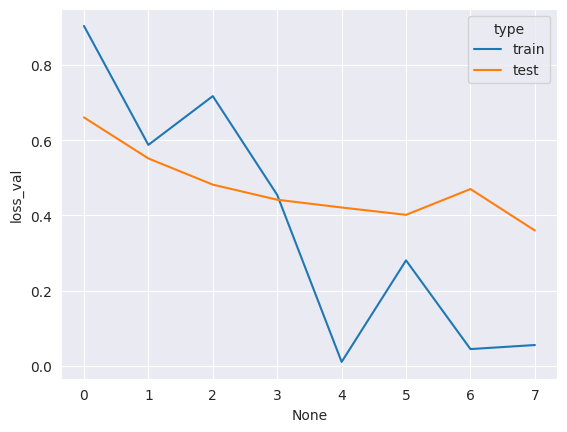

In [ ]:
visualize_losses()

/tmp/ipython-input-2276806770.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_prob = F.softmax(outputs).detach().cpu().numpy()


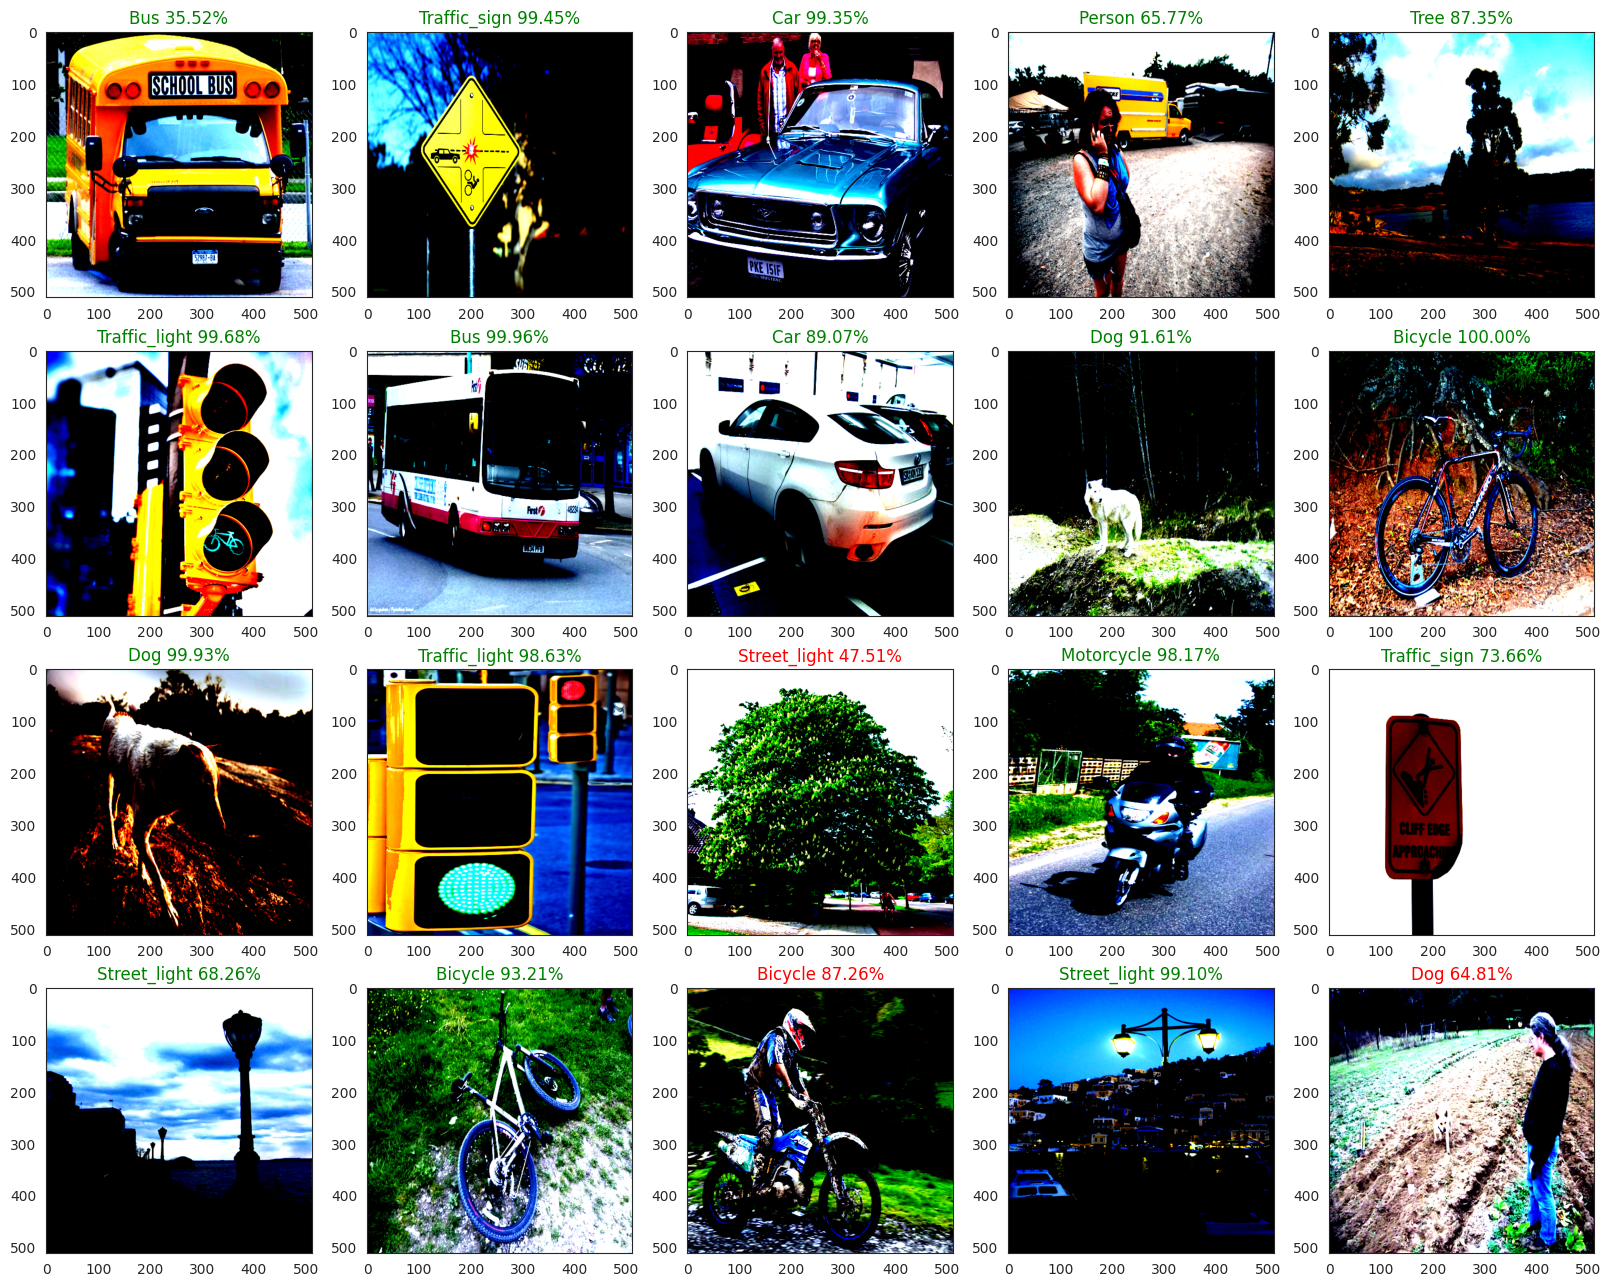

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)

outputs = net(images)
labels = np.array(labels)

# Cross Entropy loss already applied Softmax, now we need to do it manually
outputs_prob = F.softmax(outputs).detach().cpu().numpy()
# Get most likely class
outputs = np.argmax(outputs_prob, axis=1)
probabilities = np.max(outputs_prob, axis=1)

# Map the numeric values back to classes
txt_labels = list(train_dataset.class_to_idx.keys())
outputs = [txt_labels[i] for i in outputs]
labels = [txt_labels[i] for i in labels]
sns.set_style("white")
num_images_per_axis = 5
figsize = (20,20)
figure = plt.figure(figsize=figsize)

for i in range(test_batch_size):
  ax = figure.add_subplot(num_images_per_axis, num_images_per_axis, i+1)
  wonder_type = outputs[i]
  groundtruth = labels[i]

  if groundtruth == wonder_type:
    color = "green"
  else:
    color = "red"

  img = images[i]
  img = img.permute(1,2,0).detach().cpu().numpy()

  ax.set_title(wonder_type + f" {probabilities[i]*100:.2f}%", color=color)
  ax.imshow(img)



Grad CAM

In [ ]:
import os
import numpy as np
import torch
from torch.optim import Adam
from torchvision import models
from PIL import Image, ImageFilter
from torch.autograd import Variable
import copy

def preprocess_image(pil_im, resize_im=True, img_size=224):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """

    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((img_size, img_size), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning.
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

def recreate_image(im_as_var):
  """
      Recreates images from a torch variable, sort of reverse preprocessing
  Args:
      im_as_var (torch variable): Image to recreate
  returns:
      recreated_im (numpy arr): Recreated image in array
  """
  reverse_mean = [-0.485, -0.456, -0.406]
  reverse_std = [1/0.229, 1/0.224, 1/0.225]
  recreated_im = copy.copy(im_as_var.data.numpy()[0])
  for c in range(3):
      recreated_im[c] /= reverse_std[c]
      recreated_im[c] -= reverse_mean[c]
  recreated_im[recreated_im > 1] = 1
  recreated_im[recreated_im < 0] = 0
  recreated_im = np.round(recreated_im * 255)

  recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
  return recreated_im


class CNNLayerVisualization():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]
        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)

    def visualise_layer_with_hooks(self):
        # Hook the selected layer
        self.hook_layer()
        # Generate a random image
        random_image = np.uint8(np.random.uniform(150, 180, (50, 50, 3)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            # Idea: https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030
            if i % 4 == 0:
                # We have to convert the image back to int here
                recreated = recreate_image(processed_image)

                # Upscale image
                pil_im = Image.fromarray(recreated)
                current_dim = recreated.shape[1]
                new_dim = np.uint8(np.floor(current_dim * 1.2))
                pil_im = pil_im.resize((new_dim, new_dim), Image.Resampling.LANCZOS)
                processed_image = preprocess_image(pil_im, False)
                optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)

            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image.to(device)
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                # x is not used after this point because it is only needed to trigger
                # the forward hook function
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output).cpu()
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)

        # Display the final image
        plt.imshow(self.created_image)
        plt.show()
        return self.created_image

In [ ]:
from PIL import Image
import numpy as np
import torch

class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 8)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        # If no target class, take the model prediction
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        one_hot_output = one_hot_output.to(device)
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.cpu().numpy()[0]
        # Get convolution outputs
        target = conv_output.data.cpu().numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0) # This equals ReLU
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.Resampling.LANCZOS))/255

        return cam

In [ ]:
test_dataset.class_to_idx

{'Bicycle': 0,
 'Bus': 1,
 'Car': 2,
 'Dog': 3,
 'Motorcycle': 4,
 'Person': 5,
 'Street_light': 6,
 'Traffic_light': 7,
 'Traffic_sign': 8,
 'Tree': 9}

/tmp/ipython-input-2366710694.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = mpl_color_map.get_cmap('hsv')


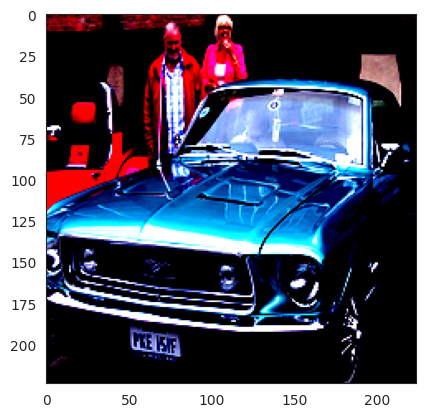

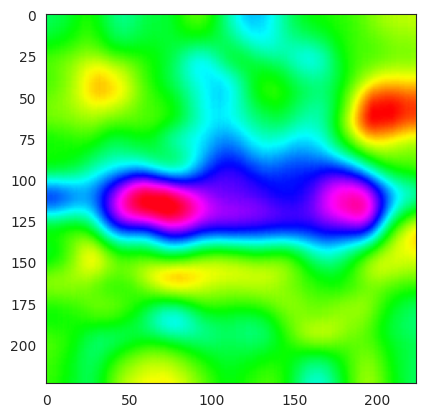

In [ ]:
import matplotlib.cm as mpl_color_map

# Redefine preprocess_image with the fix for Image.ANTIALIAS
def preprocess_image(pil_im, resize_im=True, img_size=224):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """

    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        # FIX: Replace Image.ANTIALIAS with Image.LANCZOS
        pil_im = pil_im.resize((img_size, img_size), Image.LANCZOS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning.
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

# Input
#sample_path = '/content/google_drive/My Drive/DeepFindr/CNN/test/taj_mahal/architecture-4378_1280.jpg'
# Thats very interesting!!
sample_path = "/content/google_drive/My Drive/NN/Test/Car/0003def0d18d8807.jpg"

original_image = Image.open(sample_path).convert('RGB')
prep_img = preprocess_image(original_image).to(device)
prep_img_numpy = prep_img.permute(0,2,3,1).detach().cpu()[0]
target_class = 2 # Needs to be adjusted!!
pretrained_model = net.pretrained

# Grad cam - make sure to select the relevant layer!!
grad_cam = GradCam(pretrained_model, target_layer=10) # Changed target_layer from 30 to 10
# Generate cam mask
cam = grad_cam.generate_cam(prep_img, target_class)

# Get colormap
color_map = mpl_color_map.get_cmap('hsv')
no_trans_heatmap = color_map(cam)

# Change alpha channel in colormap to make sure original image is displayed
heatmap = copy.copy(no_trans_heatmap)
heatmap[:, :, 3] = 0.4
heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

plt.imshow(prep_img_numpy)
plt.show()
plt.imshow(no_trans_heatmap)
plt.show()